<h1><center>Cruise Reviews - EDA</center></h1>

![title](images/canada-cruise-homepage.jpg)

# Importing Libraries

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pickle
import re
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction import DictVectorizer
from scipy.stats import spearmanr
#importing save and load pickle functions
import sys
sys.path.append('modules/')
from simp_pickle import load_pickle, save_pickle

# Loading Reviews

In [45]:
reviews = pd.read_csv('data/reviews.csv', index_col=0)

#renaming columns
reviews.columns = ['ship_link', 'links', 'user_date',
       'user_link', 'user_contributions',
       'user_helpful_votes', 'stars', 'title',
       'content', 'meta', 'user_hometown']

# Data cleaning

In [3]:
#Checking the number of observations and columns
reviews.shape

(9607, 11)

In [4]:
#Checking how data looks like
reviews.head(3)

ship_link  \
0  /Cruise_Review-d15691636-Reviews-MSC_Meraviglia   
1  /Cruise_Review-d15691636-Reviews-MSC_Meraviglia   
2  /Cruise_Review-d15691636-Reviews-MSC_Meraviglia   

                                               links         user_date  \
0  /ShowUserReviews-g1-d15691636-r743487186-MSC_M...  Tony K|Yesterday   
1  /ShowUserReviews-g1-d15691636-r743427041-MSC_M...   ann b|Yesterday   
2  /ShowUserReviews-g1-d15691636-r743305803-MSC_M...   Lsabina11|5 Feb   

               user_link user_contributions user_helpful_votes  stars  \
0  /Profile/L9746OCtonyk                 62                  5     40   
1       /Profile/bhayden                 10                 11     10   
2     /Profile/Lsabina11                289                 57     50   

                               title  \
0          MSC Meraviglia Yacht Club   
1                        never again   
2  Awesome experience at great value   

                                             content  \
0  We sailed on the MSC Meraviglia for the first ...   
1  This ship is a huge nightmare.  I am in decent...   
2  Four of us just came back from a MSC Meravigli...   

                                                meta        user_hometown  
0  Sail Date: January 2020|Cabin Type: Balcony|Ty...  Seattle, Washington  
1  Sail Date: February 2020|Cabin Type: Balcony|T...      orchard park NY  
2  Sail Date: February 2020|Cabin Type: Balcony|T...     Innisfil, Canada

In [5]:
# Information about data types and non-null values
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9607 entries, 0 to 9606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ship_link           9607 non-null   object
 1   links               9607 non-null   object
 2   user_date           9607 non-null   object
 3   user_link           9607 non-null   object
 4   user_contributions  9607 non-null   object
 5   user_helpful_votes  9607 non-null   object
 6   stars               9607 non-null   int64 
 7   title               9607 non-null   object
 8   content             9607 non-null   object
 9   meta                9596 non-null   object
 10  user_hometown       7661 non-null   object
dtypes: int64(1), object(10)
memory usage: 900.7+ KB


**Observation:** User contributions and helpful votes should be integers, however since the original numbers on the website included commas, this were considered as strings by pandas. The following should fix it.

In [6]:
# Cleaning fields and casting them as integer columns.
reviews.user_contributions = reviews.user_contributions.str.replace(',','').astype(int)
reviews.user_helpful_votes = reviews.user_helpful_votes.str.replace(',','').astype(int)

**Observation:** User Name and Date are in the same column.

In [7]:
#Extracting User Name
reviews['user'] = reviews.user_date.apply(lambda x: x.split('|')[0].strip())
#Extracting Date
reviews['date'] = reviews.user_date.apply(lambda x: x.split('|')[1].strip())
reviews['date'] = reviews['date'].apply(lambda x: x if x[-4:-2] == '20' else 'Feb 2020')
# Extracting year from date
reviews['year'] = reviews['date'].apply(lambda x: x.split(' ')[1])
reviews['month'] = reviews['date'].apply(lambda x: x.split(' ')[0])

**Observation:** Meta column contains multiple features.

In [8]:
reviews.head(3).meta.values

array(['Sail Date: January 2020|Cabin Type: Balcony|Type of Trip: |Destination: Caribbean|',
       'Sail Date: February 2020|Cabin Type: Balcony|Type of Trip: |Destination: Caribbean|',
       'Sail Date: February 2020|Cabin Type: Balcony|Type of Trip: Family (older kids)|Destination: Caribbean|'],
      dtype=object)

In [9]:
reviews.drop(reviews[reviews.meta.isnull()].index,inplace = True)

In [10]:
#Extracting columns data from meta data
reviews['sail_date'] = reviews['meta'].apply(lambda x: x.split('|')[0].replace('Sail Date: ',''))
reviews['cabin_type'] = reviews['meta'].apply(lambda x: x.split('|')[1].replace('Cabin Type: ',''))
reviews['trip_type'] = reviews['meta'].apply(lambda x: x.split('|')[2].replace('Type of Trip: ',''))
reviews['destination'] = reviews['meta'].apply(lambda x: x.split('|')[3].replace('Destination: ',''))
reviews.replace({'':np.NaN},inplace = True)

In [11]:
def extract_country(hometown):
    try:
        return hometown.split(',')[1].strip()
    except:
        return hometown

reviews['user_country'] = reviews.user_hometown.apply(extract_country)

**Observation:** Stars are are represented as multiples of 10: 1 star = 10 and 5 stars = 50. I will remove the last zero. 

In [12]:
reviews['stars'] = (reviews['stars']/10).astype(int)

**Getting word count**

In [13]:
reviews['word_count'] = reviews.content.apply(
    lambda x: len(re.sub('\s\s+',' ',re.sub('([^\w\s])','',x)).split(' ')))

## Clean Data

### Data available
After cleaning the data, only 2 fields contain nulls: User hometown and trip type. Whilst "user hometown" isn't a mandatory field when users fill reviews, the type of trip must be completed. However, due to recent changes on the website, whenever the user filled sub_ratings, these would show instead of the trip type. 

![title](images/review_missing.png)


### Non-null values per field

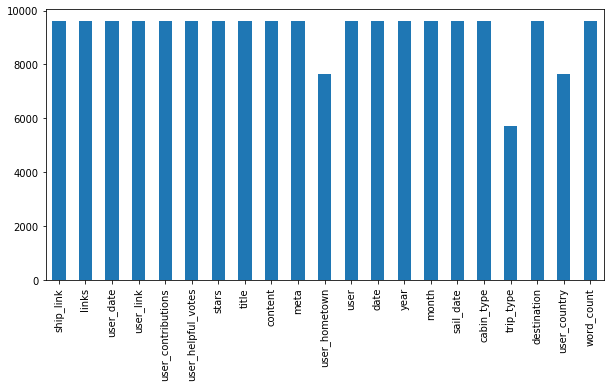

In [14]:
available_data = (len(reviews)-reviews.isna().sum())
fig, ax = plt.subplots(figsize = (10,5));
available_data.plot(kind = 'bar');

### Content word count

## Target Variable

% Reviews by Rating
5    0.431013
4    0.246978
3    0.151209
2    0.087328
1    0.083472
Name: stars, dtype: float64

Total Reviews by Rating


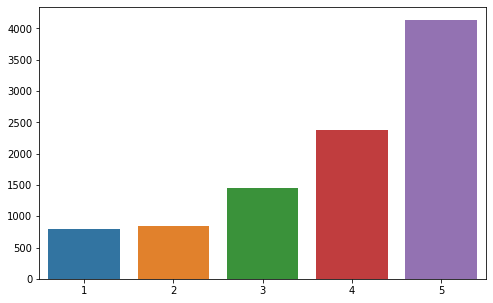

In [15]:
star_counts = reviews.stars.value_counts().sort_values(ascending = True)
#Printing %
print('% Reviews by Rating')
print(reviews.stars.value_counts(normalize=True))
#Plotting %
print('\nTotal Reviews by Rating')
plt.figure(figsize=(8,5));
sns.barplot(x = star_counts.index, y = star_counts.values,);

### Relabeling Stars

In [16]:
reviews['stars_grouped'] = reviews.stars.map({1:'Bad Review',
                                              2:'Bad Review',
                                              3:'Bad Review',
                                              4:'Good Review',
                                              5:'Good Review'})

% Reviews by Label
 Good Review    0.677991
Bad Review     0.322009
Name: stars_grouped, dtype: float64

Total Reviews by Label


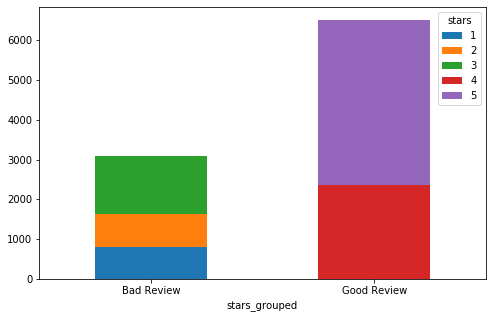

In [17]:
print('% Reviews by Label\n',reviews.stars_grouped.value_counts(normalize=True))
print('\nTotal Reviews by Label')
fig, ax = plt.subplots(figsize=(8,5));
reviews.groupby(['stars_grouped','stars'])['stars'].count().unstack().plot.bar(stacked = True, ax = ax);
ax.set_xticklabels(ax
                   .get_xticklabels(), rotation=0);

### Available Data

**Review Specific**
- Stars: Rating given by user
- Title: Review Title
- Content: Review (text without title)
- Date: Review Date (MONTH AND YEAR)

**User Specific**
- User: User name
- User Contributions: Number of reviews, pictures uploaded, etc (not just other reviews).
- User Helpful votes: ????
- User Country: Obtained from user location. NEEDS CLEANING!!!! US STATES appear as countries, some broken data too. 

**Trip Additional info**
- Sail date: When did the user travelled.
- Cabin Type: Balcony, Outside, Inside, Suite
- Trip Type: Solo, Friends, Couple, Family (Younger Kids), Family (Older Kids), Family Multi-Generational -(Incomplete)
-Destionation: Destionation of cruise. Might need additional cleaning. 

**Other Information**
-Besides the main data displayed below, I also have:
    - User link --> Could be used to download all user reviews and connect with current data.
    - Ship Link --> Can be used to download additional cruise information (size of cruise, destinations, etc).


In [18]:
reviews[['stars_grouped','stars','title','content','date',
         'user','user_contributions','user_helpful_votes','user_country',
         'sail_date','cabin_type', 'trip_type', 'destination']].head(3)

stars_grouped  stars                              title  \
0   Good Review      4          MSC Meraviglia Yacht Club   
1    Bad Review      1                        never again   
2   Good Review      5  Awesome experience at great value   

                                             content      date       user  \
0  We sailed on the MSC Meraviglia for the first ...  Feb 2020     Tony K   
1  This ship is a huge nightmare.  I am in decent...  Feb 2020      ann b   
2  Four of us just came back from a MSC Meravigli...  Feb 2020  Lsabina11   

   user_contributions  user_helpful_votes     user_country      sail_date  \
0                  62                   5       Washington   January 2020   
1                  10                  11  orchard park NY  February 2020   
2                 289                  57           Canada  February 2020   

  cabin_type            trip_type destination  
0    Balcony                  NaN   Caribbean  
1    Balcony                  NaN   Caribbean  
2    Balcony  Family (older kids)   Caribbean

**Note**: Although Trip Type is a mandatory field when submitting a review, it seems that when the subscores (which are optional) are displayed, the Trip Type stops being displayed. 

In [19]:
reviews.to_csv('data/reviews_step_1.csv')

# EDA

## Numerical variables

In [20]:
reviews = pd.read_csv('data/reviews_step_1.csv', index_col=0)
reviews.shape

(9596, 22)

### Pairplots
**Initial analysis of numerical vairables** *The only 2 numerical variables at this time are user_contributions and user_helpful_votes.*

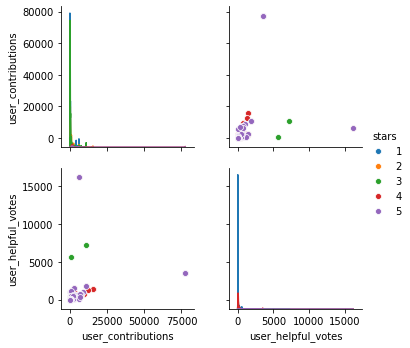

In [21]:
sns.pairplot(reviews,vars = ['user_contributions','user_helpful_votes'], hue = 'stars');

*These visualisations aren't very helpful. I'm going to change the scale of the histogrames to see if there are any patterns*

### Histograms (Y Log-scaled)

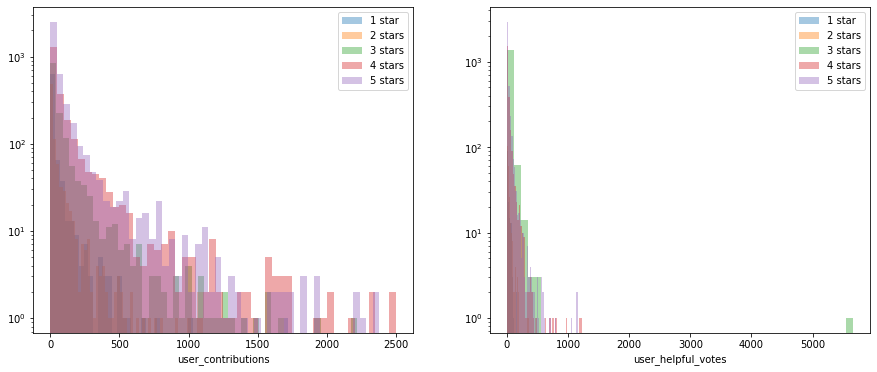

In [22]:
cont_outliers = (reviews['user_contributions']>2500)
help_outliers = (reviews['user_contributions']>2000)
fig, ax = plt.subplots(figsize = (15,6), ncols = 2)
for x in [1,2,3,4,5]:
    sns.distplot(reviews[(reviews.stars == x)&~cont_outliers]['user_contributions'],
                 ax = ax[0],hist = True, kde = False)
    ax[0].set_yscale('log')
    ax[0].legend(['1 star','2 stars','3 stars','4 stars','5 stars'])
for x in [1,2,3,4,5]:
    sns.distplot(reviews[(reviews.stars == x)&~help_outliers]['user_helpful_votes'],
                 ax = ax[1],hist = True, kde = False)
    ax[1].set_yscale('log')
    ax[1].legend(['1 star','2 stars','3 stars','4 stars','5 stars'])


*There are not significant differences in the distribution of user_contributions by rating: Across al star ratings there are a vast majority of reviews written by users with a small number of previous contributions.*

## Categorical Variables

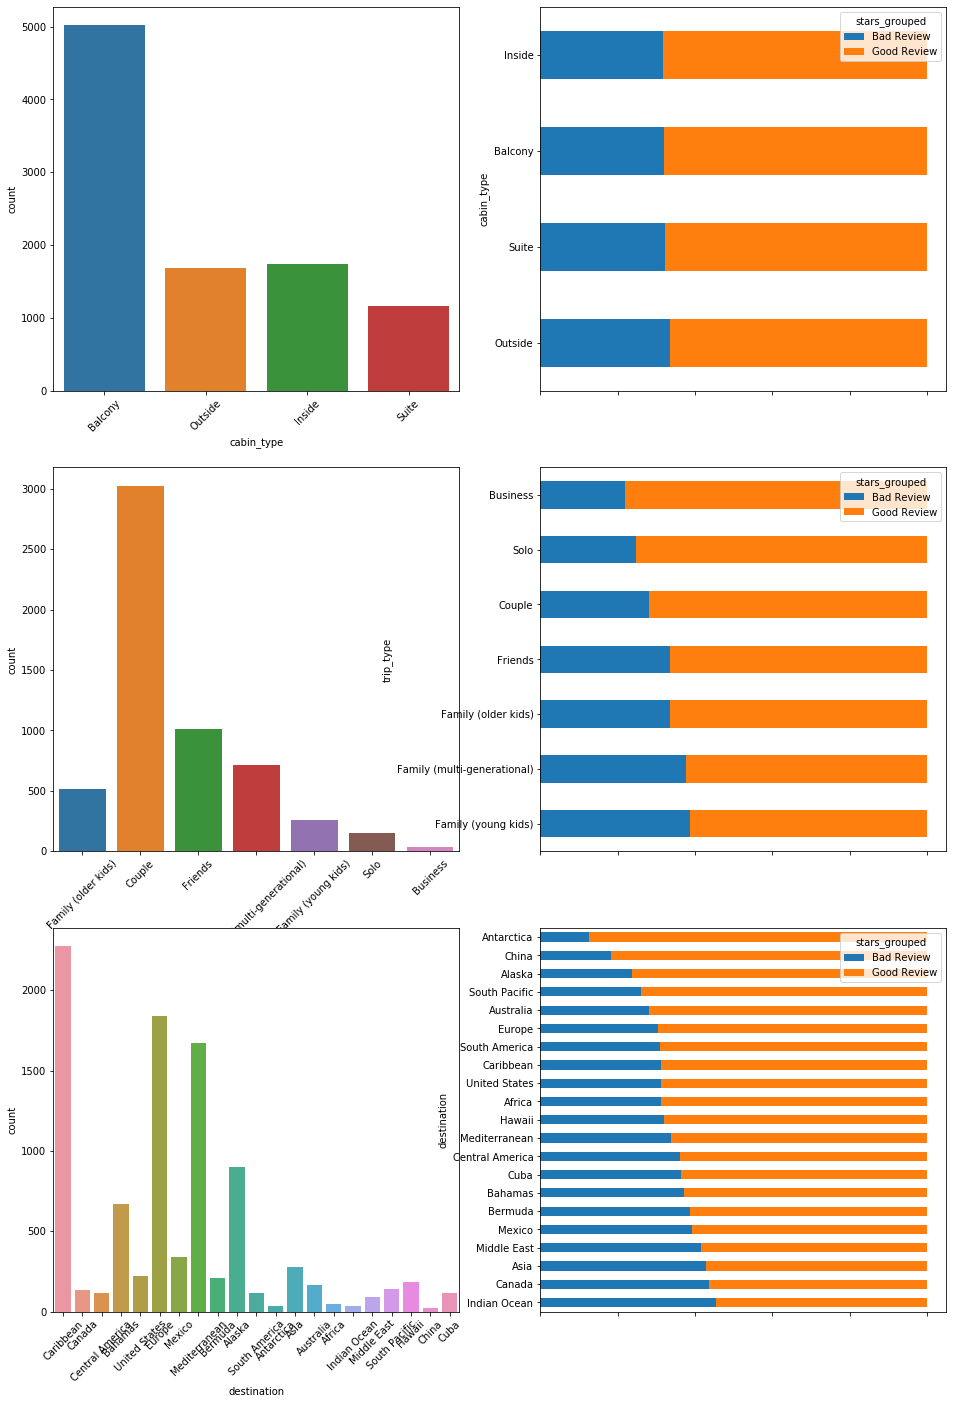

In [23]:
columns = ['cabin_type', 'trip_type', 'destination']

fig, ax = plt.subplots(nrows =len(columns), ncols = 2, figsize = (16,len(columns)*8))

for coln in range(len(columns)):
        sns.countplot(x = columns[coln], data = reviews, ax = ax[coln,0])
        ax[coln,0].set_xticklabels(ax[coln,0].get_xticklabels(), rotation=45)
        A = reviews.groupby(['stars_grouped',columns[coln]])['title'].count().unstack() 
        B = reviews.groupby(['stars_grouped',columns[coln]])['title'].count().unstack().sum()
        reviews.groupby(['stars_grouped',columns[coln]])['title'].count().unstack().sum()
        (A/B).T.sort_values(by = 'Bad Review', ascending = False).plot(kind = 'barh', stacked = True,ax = ax[coln,1])
        ax[coln,1].set_xticklabels(ax[coln,1].get_xticklabels(), rotation=45)


The charts on the left hand side in the section above depicts how the number of reviews is distributed across the 3 main categorical variables: cabin type, trip type and destination. The charts on the right hand side show the proportion of good and bad reviews per category. 

- Whilst there is a majority of users who have stayed on cabins with balcony, the are no significant differences in the proportion of good and abd reviews by cabin type. 


- There are only 5,708 trip_type records out of 9,596 reviews. This is due to TripAdvisor not displaying trip type if the user submits sub-ratings (scores for different aspects of the ship). The charts above are based on the 5,708 records available. It can be seen that there is a majority of reviews written by users who travelled with their partners, while the least popular trip type is travelling for business. **Interestingly, when looking at the proportion of good and bad reviews per trip type, it can be seen that reviews tend to be more negative the larger the group of people who travelled together**. 


- The charts show that the Caribbean and Europe are the most popular destinations. However, it is worth mentioning that the categories aren't well organised. For example, Cuba, Bahamas and parts of Mexico clearly belong to the Caribbean sea but are displayed separately. **There are significant differences in the ratio of good/bad reviews per destination. Note that the most extreme cases are those of destinations with smaller number of reviews.**

## Word Count

Text(0.5, 1.0, 'Word Count by Good/Bad Reviews')

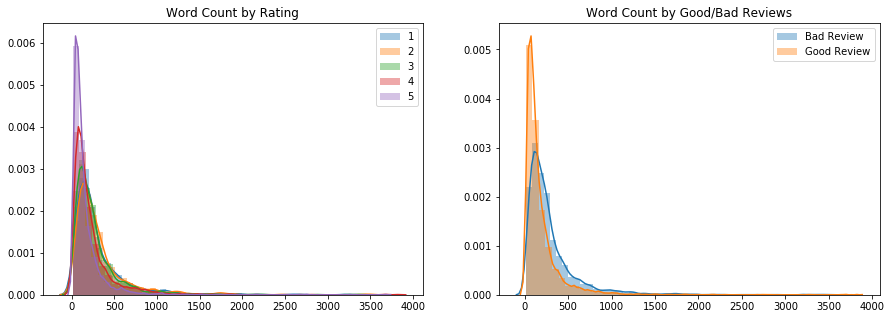

In [24]:
fig, ax = plt.subplots(figsize = (15,5),ncols = 2)

analysis = ['stars','stars_grouped']
analysis_dict = {'stars' : [1,2,3,4,5], 'stars_grouped' :['Bad Review','Good Review']}
values = ['word_count']
titles = ['Word Count']

for a in range(len(analysis)):
    for v in range(len(values)):
        for c in analysis_dict[analysis[a]]:
            sns.distplot(reviews[reviews[analysis[a]] == c][values[v]],ax = ax[a],hist = True, kde = True)
            ax[a].legend(analysis_dict[analysis[a]])
            ax[a].set_xlabel('')
ax[0].set_title('Word Count by Rating')
ax[1].set_title('Word Count by Good/Bad Reviews')

## Extracting Sentiment Analysis using Vader

In [25]:
analyzer = SentimentIntensityAnalyzer()

### Title Sentiment

In [26]:
vader_title_scores = reviews['title'].map(analyzer.polarity_scores)

In [27]:
dvec_titles = DictVectorizer()
vader_title_scores = dvec_titles.fit_transform(vader_title_scores)
for i, col in enumerate(dvec_titles.feature_names_):
    reviews['vader_title_{}'.format(col)] = vader_title_scores[:, i].toarray().ravel()

### Content Sentiment

In [28]:
vader_content_scores = reviews['content'].map(analyzer.polarity_scores)

In [29]:
dvec_content = DictVectorizer()
vader_content_scores = dvec_content.fit_transform(vader_content_scores)
for i, col in enumerate(dvec_content.feature_names_):
    reviews['vader_content_{}'.format(col)] = vader_content_scores[:, i].toarray().ravel()

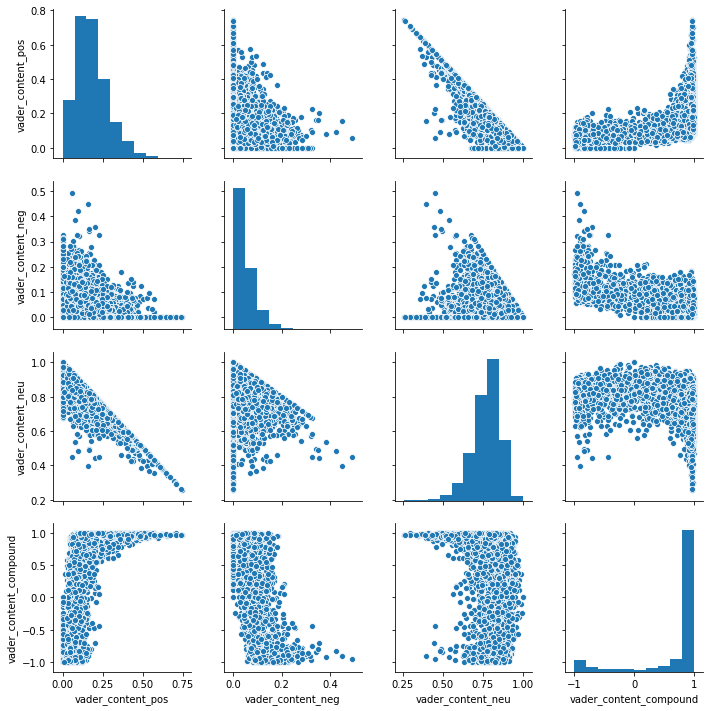

In [30]:
sns.pairplot(reviews[['vader_content_pos','vader_content_neg',
                      'vader_content_neu','vader_content_compound','stars']],
            vars = reviews[['vader_content_pos','vader_content_neg',
                            'vader_content_neu','vader_content_compound']]);#, hue = 'stars');


In [31]:
reviews.head()

ship_link  \
0  /Cruise_Review-d15691636-Reviews-MSC_Meraviglia   
1  /Cruise_Review-d15691636-Reviews-MSC_Meraviglia   
2  /Cruise_Review-d15691636-Reviews-MSC_Meraviglia   
3  /Cruise_Review-d15691636-Reviews-MSC_Meraviglia   
4  /Cruise_Review-d15691636-Reviews-MSC_Meraviglia   

                                               links         user_date  \
0  /ShowUserReviews-g1-d15691636-r743487186-MSC_M...  Tony K|Yesterday   
1  /ShowUserReviews-g1-d15691636-r743427041-MSC_M...   ann b|Yesterday   
2  /ShowUserReviews-g1-d15691636-r743305803-MSC_M...   Lsabina11|5 Feb   
3  /ShowUserReviews-g1-d15691636-r743058989-MSC_M...      Gary J|4 Feb   
4  /ShowUserReviews-g1-d15691636-r743034517-MSC_M...    Steven L|4 Feb   

               user_link  user_contributions  user_helpful_votes  stars  \
0  /Profile/L9746OCtonyk                  62                   5      4   
1       /Profile/bhayden                  10                  11      1   
2     /Profile/Lsabina11                 289                  57      5   
3      /Profile/184garyj                  43                  23      4   
4    /Profile/stevenl495                 234                  65      5   

                                      title  \
0                 MSC Meraviglia Yacht Club   
1                               never again   
2         Awesome experience at great value   
3  First Time Cruising, where's my luggage?   
4       Meraviglia is the Wonder of the Sea   

                                             content  \
0  We sailed on the MSC Meraviglia for the first ...   
1  This ship is a huge nightmare.  I am in decent...   
2  Four of us just came back from a MSC Meravigli...   
3  For my first cruise, I enjoyed my adventure. I...   
4  We live in Playa Del Carmen, Mexico so this cr...   

                                                meta  ... word_count  \
0  Sail Date: January 2020|Cabin Type: Balcony|Ty...  ...        820   
1  Sail Date: February 2020|Cabin Type: Balcony|T...  ...        159   
2  Sail Date: February 2020|Cabin Type: Balcony|T...  ...        219   
3  Sail Date: January 2020|Cabin Type: Balcony|Ty...  ...        400   
4  Sail Date: January 2020|Cabin Type: Outside|Ty...  ...       1084   

  stars_grouped vader_title_compound  vader_title_neg vader_title_neu  \
0   Good Review                0.000              0.0           1.000   
1    Bad Review                0.000              0.0           1.000   
2   Good Review                0.891              0.0           0.159   
3   Good Review                0.000              0.0           1.000   
4   Good Review                0.000              0.0           1.000   

  vader_title_pos vader_content_compound vader_content_neg vader_content_neu  \
0           0.000                 0.9979             0.066             0.780   
1           0.000                 0.8902             0.108             0.728   
2           0.841                 0.9969             0.053             0.652   
3           0.000                 0.9747             0.048             0.841   
4           0.000                 0.9998             0.037             0.726   

  vader_content_pos  
0             0.154  
1             0.165  
2             0.295  
3             0.110  
4             0.237  

[5 rows x 30 columns]

The pairplot above helps understanding how the different sentiment scores (negative, positive, neutral, compound) interact with each other. For example:

- As expected, the compound score is clearly influenced by negative and positive scores. 
- The straight lines in the charts where compound score isn't included show the score boundaries a review can have. This is because positive, negative and neutral scores and complementary and they will always add up to 1 in total. In other word, an increase of one of these 3 scores will automatically mean a decrease on other scores. 

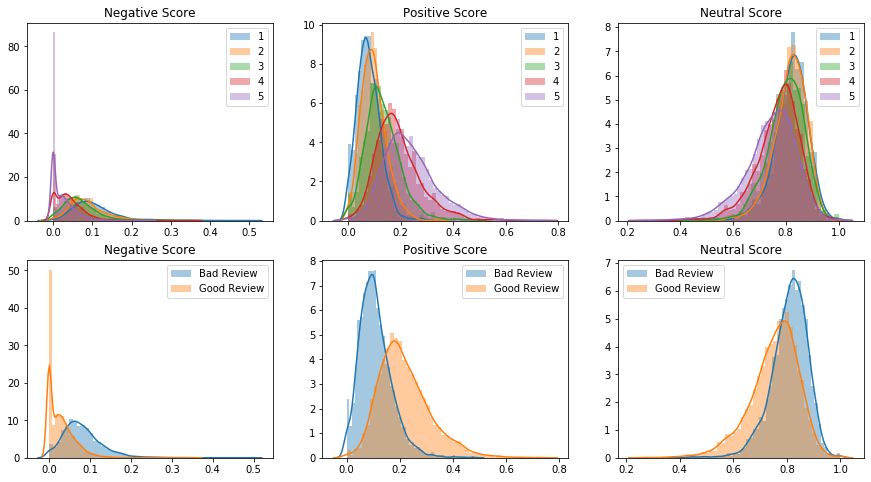

In [32]:
fig, ax = plt.subplots(figsize = (15,8),nrows = 2, ncols = 3 )

analysis = ['stars','stars_grouped']
analysis_dict = {'stars' : [1,2,3,4,5], 'stars_grouped' :['Bad Review','Good Review']}
values = ['vader_content_neg','vader_content_pos','vader_content_neu']
titles = ['Negative Score','Positive Score','Neutral Score']


for a in range(len(analysis)):
    for v in range(len(values)):
        for c in analysis_dict[analysis[a]]:
            sns.distplot(reviews[reviews[analysis[a]] == c][values[v]],ax = ax[a][v],hist = True, kde = True)
            ax[a][v].legend(analysis_dict[analysis[a]])
            ax[a][v].set_title(titles[v])
            ax[a][v].set_xlabel('')

*The top 3 charts show the distribution of positive, negative and neutral scores per rating (stars). The sentiment score distributions for every rating (1,2,3,4 and 5 stars) overlap each other to some extent. It can also be seen that 1,2 and 3 star reviews distributions are very similar, while 4 and 5 star reviews are slightly separated from the rest.*

*The bottom 3 charts shows the same scores, but this time reviews have been grouped together as described below. The separation of the bell curves is clearer on these graphs:*

Review Grouping
- 1 to 3 stars --> Bad Reviews
- 4 to 5 stars --> Good Reviews



In [33]:
reviews.to_csv('data/reviews_step_2.csv')

## Word Analysis

In [34]:
# Loading latest Data
reviews = pd.read_csv('data/reviews_step_2.csv', index_col=0)

In [35]:
#Loading libraries
import textacy
from tqdm import tqdm_notebook

In [36]:
# Tokenising all words
en_nlp = textacy.load_spacy_lang('en_core_web_sm')

def process_text(documents, pos=False):
    '''
    cleans sentences from stop words and punctuation and filters by pos tags if given
    returns cleaned sentence and tokenized sentence
    '''
    nlp = textacy.load_spacy_lang('en_core_web_sm')
    
    texts = []
    tokenised_texts = []

    if pos: # pos can either be False or a list of parts of speech
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ in pos
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
    
    
    else:    
        for document in tqdm_notebook(nlp.pipe(documents, batch_size=200)):
            assert document.is_parsed
            tokens = [token
                      for token in document 
                      if token.is_stop == False
                      and token.pos_ != 'PUNCT']
            doc_ = ''
            for token in tokens:
                doc_ += str(token) + ' '
            
            doc_ = doc_.strip()
            texts.append(doc_)
            tokenised_texts.append(tokens)
            
    return texts, tokenised_texts

texts, tokenised_text = process_text(reviews.content)

/Users/hernan/opt/anaconda3/envs/textacy/lib/python3.6/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [37]:
# Separting tokens into different columns

# Empty dictionary
type_dict = {'ADJ':[],
    'ADP':[],
    'ADV':[],
    'CCONJ':[],
    'DET':[],
    'INTJ':[],
    'NOUN':[],
    'NUM':[],
    'PART':[],
    'PRON':[],
    'PROPN':[],
    'SCONJ':[],
    'SPACE':[],
    'SYM':[],
    'VERB':[],
    'X':[]}

# Organising text in each review
for rnum in range(len(tokenised_text)):
    for key in type_dict.keys():
        type_dict[key].append('')   
    for word in tokenised_text[rnum]:
        type_dict[word.pos_][rnum]+=word.lower_+' '
    type_dict[word.pos_][rnum] = type_dict[word.pos_][rnum].strip()
    
# Creating new dataframe with wordcount and a column for each word type    
word_type = pd.DataFrame(type_dict,index = reviews.index)
word_type['word_count'] = [len(x) for x in tokenised_text]
word_type_df = word_type.join(reviews.stars_grouped)

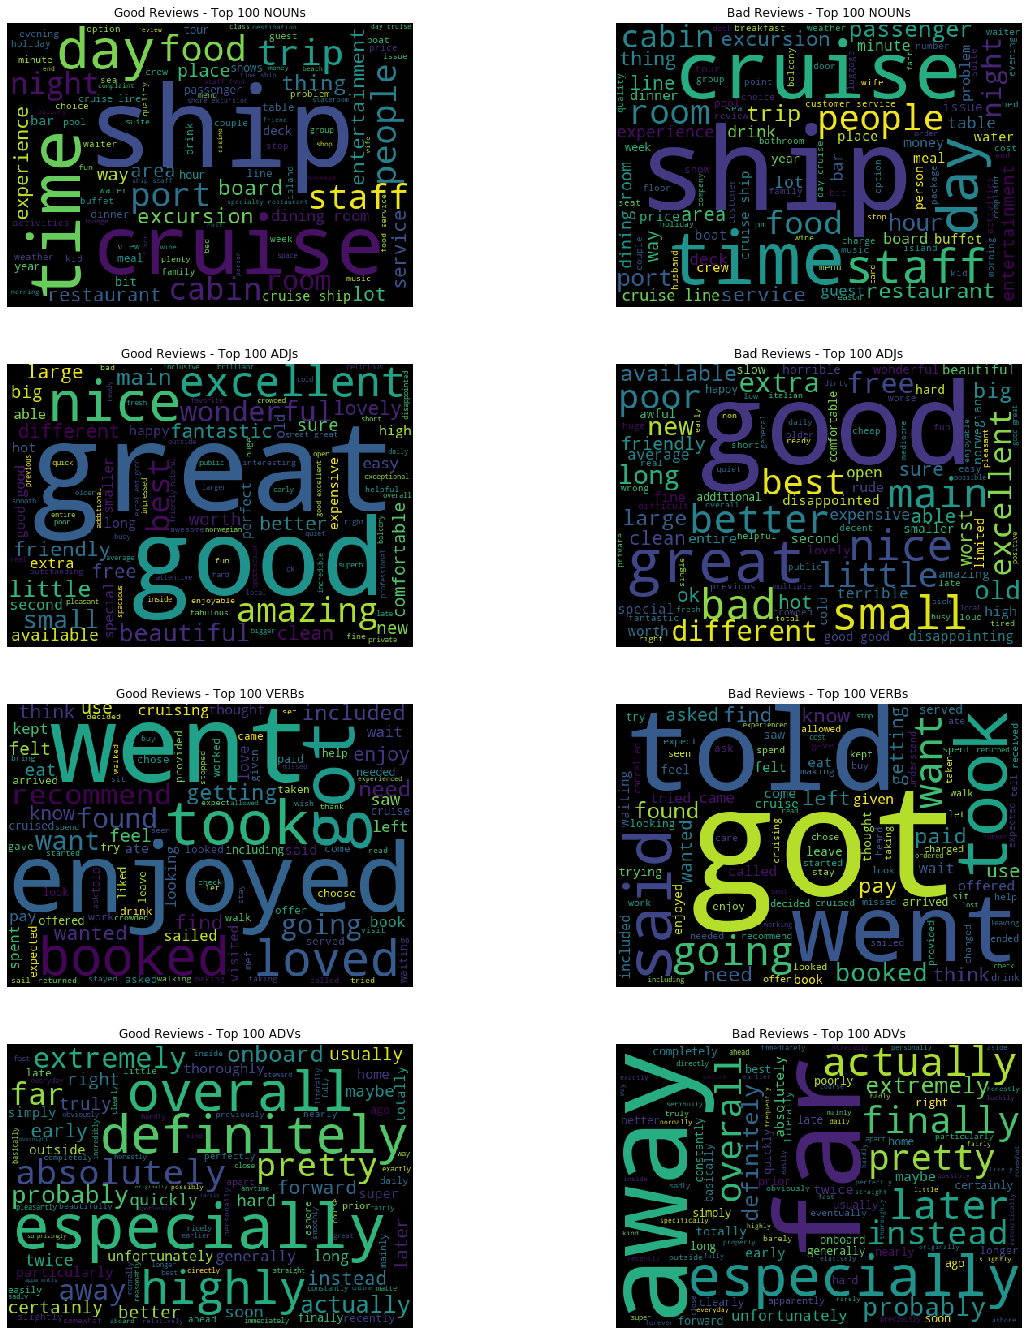

In [38]:
word_type_list = ['NOUN','ADJ','VERB','ADV']
review_type_list = ['Good Review','Bad Review']

fig, ax = plt.subplots(ncols = len(review_type_list),nrows = len(word_type_list),
                       figsize = (20,len(word_type_list)*6))


for wtype in range(len(word_type_list)):
    for rtype in range(len(review_type_list)):
        r_text = ''
        r_text= ''.join(line for line in 
                              word_type_df[word_type_df.stars_grouped==review_type_list[rtype]]
                              [word_type_list[wtype]])

        wordcloud = WordCloud(width=500,height=350, max_words=100,relative_scaling=1,normalize_plurals=True
                                 ).generate(r_text)
        
        ax[wtype][rtype].imshow(wordcloud)
        ax[wtype][rtype].axis('off')
        ax[wtype][rtype].set_title('{}s - Top 100 {}s'.format(
            review_type_list[rtype],word_type_list[wtype]))
    

The wordclouds above show that some of the most common nouns, adj, verbs and adverbs in good reviews also are the most common words on negative reviews.

In [39]:
reviews.to_csv('data/reviews_step_3.csv')

In [40]:
word_type_df.to_csv('data/word_type.csv')

### Spearman Correlation of Words

In [42]:
#Creating word frequecy table of each type of word and separating good and bad reviews:
freq_dict = {'NOUN':{},'ADJ':{},'VERB':{},'ADV':{}}

for wtype in freq_dict.keys():
    revs = zip(word_type_df[wtype],word_type_df['stars_grouped'])
    for rev, group in revs:
        for word in rev.split():
            if word not in freq_dict[wtype].keys():
                freq_dict[wtype][word] = [0,0]
            if group == 'Good Review':
                freq_dict[wtype][word][0] += 1
            else:
                freq_dict[wtype][word][1] += 1

In [43]:
#Pearson's correlation for word frequency by word type
for wtype in freq_dict.keys():
    pos = np.array([pos for pos,neg in freq_dict[wtype].values()])
    neg = np.array([neg for pos,neg in freq_dict[wtype].values()])
    print(f"Pearson's coefficient for {wtype}s is {np.corrcoef(pos,neg)[0][1]}")
    print(f"Spearman's coefficient for {wtype}s is {spearmanr(pos,neg)[0]}")


Pearson's coefficient for NOUNs is 0.983234651239971
Spearman's coefficient for NOUNs is 0.3956554921950513
Pearson's coefficient for ADJs is 0.883063291664364
Spearman's coefficient for ADJs is 0.3673273536364726
Pearson's coefficient for VERBs is 0.8714370941303468
Spearman's coefficient for VERBs is 0.4131520820033662
Pearson's coefficient for ADVs is 0.8755983863590056
Spearman's coefficient for ADVs is 0.4242706795664071
